In [86]:
import numpy as np
import numpy.matlib
%matplotlib inline
from matplotlib import pyplot as plt

In [87]:
data_file = "Data/meteo1.csv"

In [88]:
def read_data(data_file):
    # Opening file 
    file = open(data_file) 
    count = 0
    data = []
    for line in file: 
        count += 1
        dat = []
        line = line.split(" ")
        for d in line:
            dat.append(int(d))
        data.append(np.array(dat))
    
    data = np.array(data)
  
    # Closing files 
    file.close() 
    
    return data

In [89]:
data = read_data(data_file)

In [90]:
print(data.shape)

(500, 100)


In [91]:
## for a given sequence find the number of each possible transition
def find_transitions_number(sequence):
    transitions_dict = {}
    for i in range(0,3):
        for j in range(0,3):
            #print("Transition: " + str(i) + " " + str(j))
            transitions_dict[(i,j)] = 0
            
    for i in range(0,len(sequence)-1):
        transitions_dict[sequence[i],sequence[i+1]] += 1
        
    return transitions_dict

In [92]:
dict_list = []
for sequence in data:
    transitions_dict = find_transitions_number(sequence)
    dict_list.append(transitions_dict)

In [93]:
print(dict_list[0])

{(0, 0): 21, (0, 1): 4, (0, 2): 24, (1, 0): 3, (1, 1): 6, (1, 2): 2, (2, 0): 25, (2, 1): 0, (2, 2): 14}


In [94]:
## compute sufficient statistics for all the sequences
## compute the transition counts for all the possible combinations of transitions appear in a sequence
## compute also the initial state for each sequence
## reuse these numbers for all the iterations of em without have to recompute them for every iter
def compute_sufficient_statistics(S,x_1,x,dict_list):
    for i in range(len(dict_list)):
        ## receive the transition counts for the specific sequence (alreaady computed)
        transitions_dict = dict_list[i]
        # define the initial state for the given sequence
        x_1[x[i][0]][i] = 1
        # define the transition counts for the given sequence
        for k in range(0,3):
            for l in range(0,3):
                S[k][l][i] = transitions_dict.get((k,l))
                
    return S,x_1

In [95]:
# array of sequences
x = data
# number of states
D = 3
# number of hidden variables
K = 3

## number of sequences
N = data.shape[0]
## transition counts for each sequence
Transition_array = np.zeros((D,D,N))
## initial states for eaach sequence
Initial_state_array = np.zeros((D,N))

In [96]:
Transition_array,Initial_state_array = compute_sufficient_statistics(Transition_array,Initial_state_array,x,dict_list)

In [97]:
print(Transition_array[:,:,0])

[[21.  4. 24.]
 [ 3.  6.  2.]
 [25.  0. 14.]]


In [98]:
print(Initial_state_array[:,0])

[0. 1. 0.]


In [99]:
Transition_array = np.reshape(Transition_array,(D*D,N))

In [100]:
print(Transition_array[:,0])

[21.  4. 24.  3.  6.  2. 25.  0. 14.]


In [101]:
## the posterior of hidden variables
## responsibilities in other words
responsibilities = np.zeros((K,N))

In [102]:
log_likelihood = []
Max_Iters = 20

In [103]:
## normalise a matrix along its first dimension (column dimension)
def normalise(x):
    sum_term = x.sum(axis=0)
    ## if a sum is zero replace in with 1
    ## in order to avoid nan values by deviding by zero
    sum_term[sum_term == 0] = 1
    x_normed = x/sum_term
    return x_normed

In [104]:
def log_function(x):
    with np.errstate(divide='ignore'):
        res = np.log2(x)
     
    ## replace with 0 where -inf is encountered
    res[np.isneginf(res)]=0
    
    return res

In [105]:
def exponential_normalisation(x):
    
    max_values = x.max(axis=0)
    
    exponentiated_matrix = []
    for i in range(0,x.shape[1]):
        exponentited_col = np.exp(x[:,i] - max_values[i])
        exponentiated_matrix.append(exponentited_col)
        
    exponentiated_matrix = np.array(exponentiated_matrix).T
    
    return(normalise(exponentiated_matrix))

In [106]:
Transition_array,Initial_state_array

(array([[21.,  1.,  0., ...,  2., 26., 19.],
        [ 4.,  3., 10., ..., 13.,  7.,  9.],
        [24., 14., 10., ..., 11., 18., 20.],
        ...,
        [25., 12., 15., ..., 20., 22., 24.],
        [ 0., 24., 23., ..., 14.,  0.,  0.],
        [14.,  6.,  0., ...,  1., 18., 13.]]),
 array([[0., 0., 0., ..., 0., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]))

In [107]:
def expectation_step(log_p1,Initial_state_array,log_A,Transition_array,hidden_var_weight):
    
    ## expectation step
    ## update the responsibilities
    likelihood = (log_p1.T @ Initial_state_array) + (log_A.T @ Transition_array) + numpy.matlib.repmat(hidden_var_weight,1,N)
    ## exponential normalisation of the likelihood
    responsibilities = exponential_normalisation(likelihood)
    
    return likelihood, responsibilities
    

In [108]:
def maximisation_step(Initial_state_array,responsibilities,Transition_array):
    
    p1 = normalise(Initial_state_array@responsibilities.T)
    A = normalise(np.reshape(Transition_array @ responsibilities.T,(D,D,K)))
    hidden_var_weight = normalise(np.reshape((responsibilities.sum(axis = 1)),(K,1)))
    
    return p1,A,hidden_var_weight

In [109]:
def log_likelihood(x):
    c = x.max()
    return c + np.log2(np.sum(np.exp(x - c)))

In [110]:
## randomly initialise the paraameters of the model
## i pick some points uniformly and randomly using random.uniform
## but then i normalise the (based on the first dimension) because i waant a distribution
hidden_var_weight = np.random.uniform(size=(K,1))
p1 = np.random.uniform(size=(D,K))
A = np.random.uniform(size=(D,D,K))

hidden_var_weight = normalise(hidden_var_weight)
p1 = normalise(p1)
A = normalise(A)

print(np.sum(p1[:,0]))
print(np.sum(hidden_var_weight[:,0]))
print(np.sum(A[:,0,0]))

1.0
1.0
0.9999999999999999


In [111]:
log_lkl = []
iters = []

## EM training
for i in range(Max_Iters):
    
    log_p1 = log_function(p1)
    log_A = np.reshape(log_function(A),(D*D,K))
    log_hidden_var_weight = log_function(hidden_var_weight)
 
    likelihood, responsibilities = expectation_step(log_p1,Initial_state_array,log_A,Transition_array,log_hidden_var_weight)
    
    ## calculate the log likelihood
    log_likelihood_of_iteration = log_likelihood(likelihood)    
    log_lkl.append(log_likelihood_of_iteration)
    
    ## maximisation step
    ## update the parameters of the model
    p1,A,hidden_var_weight = maximisation_step(Initial_state_array,responsibilities,Transition_array)

In [112]:
def plot_likelihood(iterations,likelihood):
    
    plt.plot(iterations, likelihood, color='green', label='Log-Likelihood')
    plt.title('Log Likelihood over iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.legend()
    plt.show()
    plt.figure()

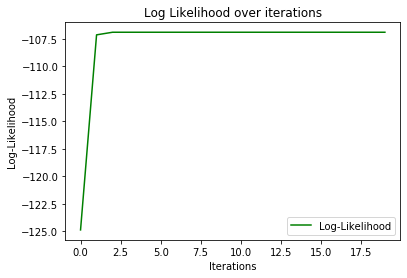

<Figure size 432x288 with 0 Axes>

In [113]:
plot_likelihood(range(Max_Iters),log_lkl)

In [114]:
print(range(Max_Iters))
print(log_lkl)

range(0, 20)
[-124.87005100301242, -107.1449702107255, -106.90836617414864, -106.90836728233305, -106.90836732514825, -106.90836700600711, -106.90836672246029, -106.90836655984934, -106.90836648590776, -106.90836646345392, -106.90836646960325, -106.90836649169235, -106.9083665226241, -106.90836655829689, -106.90836659633241, -106.90836663529377, -106.90836667390747, -106.90836671005644, -106.90836673948932, -106.9083667544205]


In [115]:
## print the responsibilities on hidden states for the first 10 sequences
for i in range(0,10):
    print("The responsibililty for the first sample is: " + str(responsibilities[:,i]) + " and sums to " + str(np.sum(responsibilities[:,i])))

The responsibililty for the first sample is: [6.57089479e-01 1.94320475e-35 3.42910521e-01] and sums to 1.0
The responsibililty for the first sample is: [6.68217600e-51 1.00000000e+00 2.54381157e-48] and sums to 1.0
The responsibililty for the first sample is: [1.94736047e-65 1.00000000e+00 1.37012318e-64] and sums to 1.0
The responsibililty for the first sample is: [1.07819280e-36 1.00000000e+00 1.70562054e-40] and sums to 1.0
The responsibililty for the first sample is: [1.78188853e-43 1.00000000e+00 1.76223360e-44] and sums to 1.0
The responsibililty for the first sample is: [5.29610419e-44 1.00000000e+00 7.38045533e-41] and sums to 1.0
The responsibililty for the first sample is: [9.99781472e-01 1.60236311e-31 2.18527629e-04] and sums to 1.0
The responsibililty for the first sample is: [7.42788974e-50 1.00000000e+00 7.44057134e-51] and sums to 1.0
The responsibililty for the first sample is: [2.97956552e-049 1.00000000e+000 1.68725337e-236] and sums to 1.0
The responsibililty for t

In [116]:
##  print the learnt parameters of the model

In [117]:
print(A)
print(np.sum(A[:,0,0]))

[[[0.38367924 0.06705976 0.42455694]
  [0.42974099 0.26172892 0.34546707]
  [0.46022152 0.35915805 0.64063269]]

 [[0.08727815 0.19128523 0.08955114]
  [0.52448051 0.25947809 0.58985401]
  [0.09331091 0.54707411 0.07179991]]

 [[0.5290426  0.74165501 0.48589192]
  [0.0457785  0.47879299 0.06467892]
  [0.44646757 0.09376783 0.2875674 ]]]
0.9999999999999999


In [118]:
print(p1)
print(np.sum(p1[:,0]))

[[4.54552790e-001 3.61386139e-001 1.94254872e-001]
 [5.45447210e-001 3.63861386e-001 8.05745128e-001]
 [2.56631467e-021 2.74752475e-001 1.92654749e-205]]
1.0


In [119]:
print(hidden_var_weight)
print(np.sum(hidden_var_weight[:,0]))

[[0.17173808]
 [0.808     ]
 [0.02026192]]
1.0
